# pyphot Quickstart

This notebook provides a quick introduction to the `pyphot` package.

Full documentation available at [https://mfouesneau.github.io/pyphot/](https://mfouesneau.github.io/pyphot/)

<div class="alert alert-block alert-info">

ℹ️ This notebook is based on **Pyphot version 2.0.0.**

</div>

<div class="alert alert-block alert-success"> 
💡 The online documentation contains also additional examples.
</div>



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Handle import for pyphot and path
import sys

try:
    import pyphot
except ImportError:
    sys.path.append("../")
    import pyphot

## Photometry Computations

Quick start example to access the library and it's content: 
- this example uses the internal (HDF) filter library.
- `f = lib.find('irac')` finds all filter names that relates to IRAC (i.e. the four bands).
- prints information about the first IRAC passband, including zeropoints in various systems.

In [3]:
import pyphot

# get the internal default library of passbands filters
lib = pyphot.get_library()
print("Library contains: ", len(lib), " filters")
# find all filter names that relates to IRAC
# and print some info
f = lib.find("irac")
passbands = lib.load_filters(f)  # or lib[f]
passbands[0].info(show_zeropoints=True)

Library contains:  271  filters
Filter object information:
    name:                 SPITZER_IRAC_36
    detector type:        photon
    wavelength units:     AA
    central wavelength:   35634.293911 Angstrom
    pivot wavelength:     35569.270678 Angstrom
    effective wavelength: 35134.320010 Angstrom
    photon wavelength:    35263.773954 Angstrom
    minimum wavelength:   31310.000000 Angstrom
    maximum wavelength:   39740.000000 Angstrom
    norm:                 3181.966405
    effective width:      6848.829972 Angstrom
    fullwidth half-max:   7430.000000 Angstrom
    definition contains 505 points
    Zeropoints
        Vega: 27.948397 mag,
              6.616697169302651e-12 erg / (Angstrom s cm2),
              279.2354008243633 Jy
              5.5117355961901255 ph / (Angstrom s cm2)
          AB: 25.163323 mag,
              8.603413213872212e-11 erg / (Angstrom s cm2),
              3630.7805477009956 Jy
          ST: 21.100000 mag,
              3.6307805477010028e-

Suppose one has a calibrated spectrum and wants to compute the vega magnitude through the HST WFC3 F110W and F160W passband,
- we use the internal Vega spectrum as example
- we load the WFC3 F110W passband from the internal filter library
- we compute the magnitude using the `get_flux` method of the passband

In [4]:
# We'll use Vega spectrum as example
from pyphot.vega import Vega

vega = Vega()
passbands = lib.load_filters(["HST_WFC3_F110W", "HST_WFC3_F160W"])
# compute the integrated flux through the filter f
# note that it work on many spectra at once
for f in passbands:
    print(f"Passband: {f.name}")
    fluxes = f.get_flux(vega.wavelength, vega.flux, axis=-1)
    # convert to vega magnitudes
    mags = -2.5 * np.log10(fluxes.value) - f.Vega_zero_mag
    print("- Vega magnitude of Vega in {0:s} is : {1:0.3f} mag".format(f.name, mags))
    mags = -2.5 * np.log10(fluxes.value) - f.AB_zero_mag
    print("-   AB magnitude of Vega in {0:s} is : {1:0.3f} mag".format(f.name, mags))
    mags = -2.5 * np.log10(fluxes.value) - f.ST_zero_mag
    print("-   ST magnitude of Vega in {0:s} is : {1:0.3f} mag".format(f.name, mags))

Passband: HST_WFC3_F110W
/spectrum._v_attrs (AttributeSet), 16 attributes
- Vega magnitude of Vega in HST_WFC3_F110W is : 0.000 mag
-   AB magnitude of Vega in HST_WFC3_F110W is : 0.752 mag
-   ST magnitude of Vega in HST_WFC3_F110W is : 2.373 mag
Passband: HST_WFC3_F160W
- Vega magnitude of Vega in HST_WFC3_F160W is : 0.000 mag
-   AB magnitude of Vega in HST_WFC3_F160W is : 1.256 mag
-   ST magnitude of Vega in HST_WFC3_F160W is : 3.502 mag


<div class="alert alert-warning">

⚠️ **Important** `UnitTypeError: Can only apply 'log10' function to dimensionless quantities`

You may encounter a `UnitTypeError` error if you try to compute `log10` (and other non trivial transformations) directly from quantities with units
In this example, it is unclear what Python needs to do with logarithm of flux in flam (erg/s/cm2/Angstrom). You need to either convert the flux to a dimensionless quantity first, e.g. by dividing by a reference flux (e.g., `f.Vega_zero_flux, f.AB_zero_flux, f.ST_zero_flux`), or take `.value` to work with the float. 

</div>

The following code illustrate how to quickly plot passbands based on the ones we queried above.

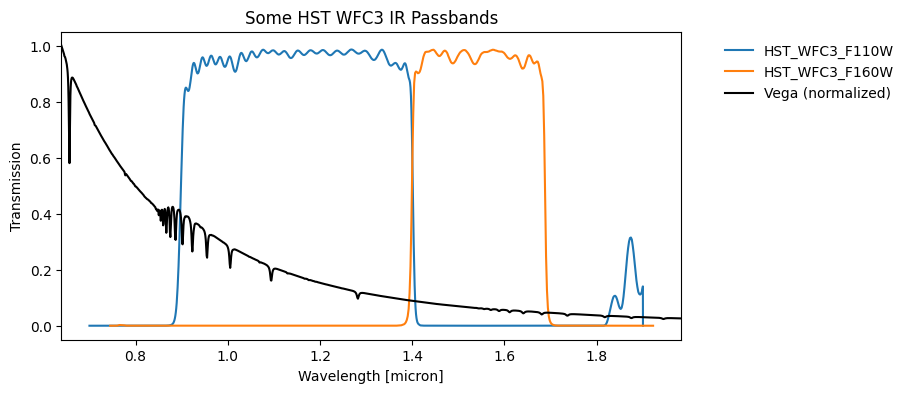

In [5]:
plt.figure(figsize=(8, 4))
for f in passbands:
    plt.plot(f.wavelength.to("micron"), f.transmit, label=f.name)
xlim = plt.xlim()
vega_w = vega.wavelength.to("micron")
ind = (vega_w.value >= xlim[0]) & (vega_w.value <= xlim[1])
vega_f = vega.flux.to("flam")[ind]
plt.plot(
    vega_w[ind], vega_f / vega_f.max(), label="Vega (normalized)", color="k", ls="-"
)
plt.xlim(xlim)
plt.legend(loc="best", frameon=False, bbox_to_anchor=(1.05, 1))
plt.xlabel("Wavelength [micron]")
plt.ylabel("Transmission")
plt.title("Some HST WFC3 IR Passbands");

<div class="alert alert-block alert-info">

ℹ️ See [online documentation](https://mfouesneau.github.io/pyphot/libcontent.html) for more details about the internal library content.

</div>

## Vega spectra

`pyphot` provides convenient interfaces to a spectral representation of Vega (aka Lyrae, HD 172167) serves as the fundamental calibration standard for stellar photometry due to its exceptional brightness, and favorable observational characteristics.).
Since version 1.7.0, Pyphot includes a set of Vega flavors one can use transparently as photometric standards. The [online documentation](https://mfouesneau.github.io/pyphot/vega.html) provides more details about the differences between the various Vega spectra available in `pyphot`.

<div class="alert alert-block alert-info">

ℹ️ `stis_003` (aliased also to legacy) is the default Vega flavor (and the only one before version 1.7.0). This flavor is also the reference for the values provided in the documentation.

</div>

In [6]:
import pyphot.config
from pyphot import Filter
import numpy as np

units = pyphot.config.units
# Create a passband using the Vega flavor
pb = Filter(
    np.array([4000, 5000, 6000]) * units.U("AA"),
    np.array([0.1, 0.8, 0.1]),
    name="Example Passband",
    dtype="photon",
    vega="stis_011",  # Specify the Vega flavor,
)
pb.info()

Filter object information:
    name:                 Example Passband
    detector type:        photon
    wavelength units:     Angstrom
    central wavelength:   5000.000000 Angstrom
    pivot wavelength:     4988.465959 Angstrom
    effective wavelength: 4889.062473 Angstrom
    photon wavelength:    4930.109597 Angstrom
    minimum wavelength:   4000.000000 Angstrom
    maximum wavelength:   6000.000000 Angstrom
    norm:                 900.000000
    effective width:      1125.000000 Angstrom
    fullwidth half-max:   1000.000000 Angstrom
    definition contains 3 points
    Zeropoints
        Vega: 20.816392 mag,
              4.71458070138158e-09 erg / (Angstrom s cm2),
              3913.419432181145 Jy
              948.5551661217513 ph / (Angstrom s cm2)
          AB: 20.897783 mag,
              4.374079548023883e-09 erg / (Angstrom s cm2),
              3630.7805477010006 Jy
          ST: 21.100000 mag,
              3.6307805477010028e-09 erg / (Angstrom s cm2),
         

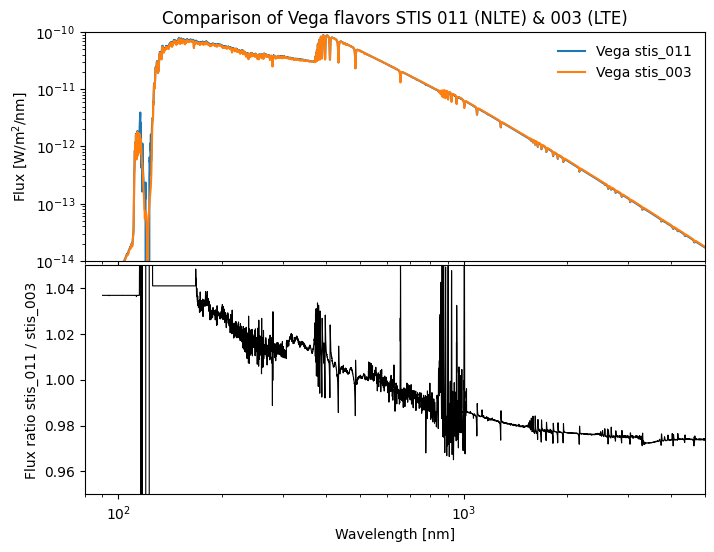

In [7]:
import numpy as np

v11 = Vega(flavor="stis_011")
v03 = Vega(flavor="stis_003")

# let's make the plot in W/m2/nm vs nm
flux_in = "W * m**-2 * nm**-1"
wave_in = "nm"

_, axes = plt.subplots(
    2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"hspace": 0.02, "wspace": 0.02}
)
axes[0].loglog(v11.wavelength.to(wave_in), v11.flux.to(flux_in), label="Vega stis_011")
axes[0].loglog(v03.wavelength.to(wave_in), v03.flux.to(flux_in), label="Vega stis_003")
axes[0].set_ylabel("Flux [W/m$^2$/nm]")
axes[0].set_ylim(1e-14, 1e-10)
axes[0].legend(loc="best", frameon=False)

v03_flux_interp = np.interp(v11.wavelength, v03.wavelength, v03.flux)
axes[1].semilogx(
    v11.wavelength.to(wave_in), (v11.flux / v03_flux_interp), color="k", lw=0.8
)
axes[1].set_ylabel("Flux ratio stis_011 / stis_003")
axes[1].set_xlabel("Wavelength [nm]")
axes[1].set_ylim(0.95, 1.05)
axes[1].set_xlim(80, 5e3)
axes[0].set_title("Comparison of Vega flavors STIS 011 (NLTE) & 003 (LTE)");

## Sun

The internal reference to the Solar spectrum comes in two flavors: an observed one and a theoretical one.
By default, the interface is set to theoretical. The theoretical spectrum is based on the Kurucz 1993 model of the Solar atmosphere, while the observed spectrum is a composite one built from various sources. It has the advantage of having a better wavelength coverage, especially in the UV and IR.  No solar spectrum is not a reference in photometric system definitions.

The theoretical spectrum is scaled to match the observed spectrum from 1.5 - 2.5 microns, and then it is used where the observed spectrum ends. The theoretical model of the Sun from Kurucz‘93 atlas using the following parameters when the Sun is at 1 au.

|log_Z | T_eff | log_g | V$_{Johnson}$ |
|------|-------|-------|---------------|
|+0.0  | 5777  |+4.44  | -26.76        |

The Sun is also know to have a Johnson V (vega-)magnitude of -26.76 mag (+4.81 mag if at 10 pc; absolute magnitude).

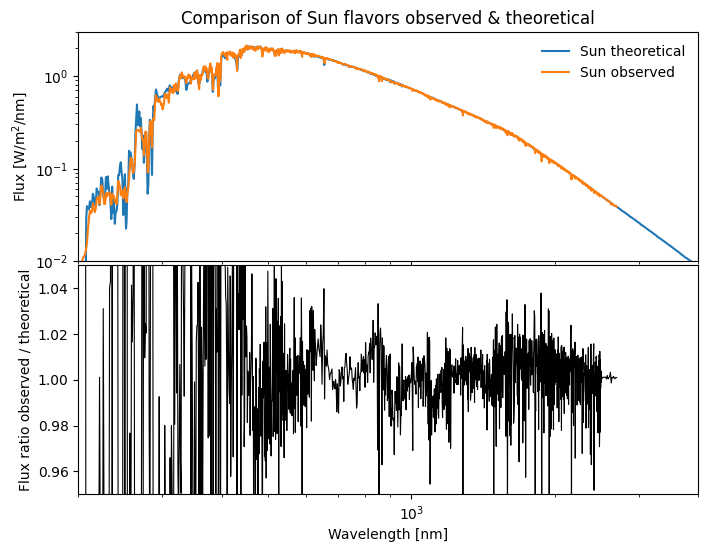

In [8]:
from pyphot import Sun

sun_obs = Sun(flavor="observed")
sun_th = Sun()

# let's make the plot in W/m2/nm vs nm
flux_in = "W * m**-2 * nm**-1"
wave_in = "nm"

_, axes = plt.subplots(
    2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"hspace": 0.02, "wspace": 0.02}
)
axes[0].loglog(
    sun_th.wavelength.to(wave_in), sun_th.flux.to(flux_in), label="Sun theoretical"
)
axes[0].loglog(
    sun_obs.wavelength.to(wave_in), sun_obs.flux.to(flux_in), label="Sun observed"
)
axes[0].set_ylabel("Flux [W/m$^2$/nm]")
axes[0].set_ylim(1e-2, 3)
axes[0].legend(loc="best", frameon=False)

v03_flux_interp = np.interp(sun_obs.wavelength, sun_th.wavelength, sun_th.flux)
axes[1].semilogx(
    sun_obs.wavelength.to(wave_in), (sun_obs.flux / v03_flux_interp), color="k", lw=0.8
)
axes[1].set_ylabel("Flux ratio observed / theoretical")
axes[1].set_xlabel("Wavelength [nm]")
axes[1].set_ylim(0.95, 1.05)
axes[1].set_xlim(200, 4e3)
axes[0].set_title("Comparison of Sun flavors observed & theoretical");

Let's also compute the Johnson V magnitude of the Sun using both the observed and theoretical spectra, as well as the theoretical spectrum placed at 10 pc to check the expected values.

In [9]:
sun_th_10pc = Sun(flavor="theoretical", distance=10 * units.U("pc"))
f = lib["GROUND_JOHNSON_V"]
print(f"| {'Which':12s} | {'Flux (flam)':<10s} | {'M(V) mag':<10s}|")
print("+--------------+-------------+-----------+")
for name, sun in zip(
    ("observed", "theoretical", "th. 10pc"), (sun_obs, sun_th, sun_th_10pc)
):
    flux = f.get_flux(sun.wavelength, sun.flux)
    print(
        "| {0:12s} | {1:0.5e} | {2:+9.2f} |".format(
            name, flux.to("flam").value, -2.5 * np.log10(flux / f.Vega_zero_flux)
        )
    )

| Which        | Flux (flam) | M(V) mag  |
+--------------+-------------+-----------+
| observed     | 1.84614e+02 |    -26.76 |
| theoretical  | 1.84436e+02 |    -26.76 |
| th. 10pc     | 4.33507e-11 |     +4.81 |


Finally, we can also look at the colors and other passbands. We'll use the Sun at 10 pc for that.

In [10]:
filter_names = [
    "GROUND_JOHNSON_B",
    "GROUND_JOHNSON_V",
    "GROUND_BESSELL_J",
    "GROUND_BESSELL_K",
]
filter_names += lib.find("GaiaDR2")

filters = lib.load_filters(filter_names, lamb=sun_th.wavelength)

mags = {}
for name, fn in zip(filter_names, filters):
    flux = fn.get_flux(sun_th_10pc.wavelength, sun_th_10pc.flux)
    vegamag = fn.Vega_zero_mag
    mag = -2.5 * np.log10(flux.value) - vegamag
    mags[name] = mag
    print("{0:>25s} {1:+3.4f} mag".format(name, mag))

         GROUND_JOHNSON_B +5.5012 mag
         GROUND_JOHNSON_V +4.8084 mag
         GROUND_BESSELL_J +3.6751 mag
         GROUND_BESSELL_K +3.3015 mag
               GaiaDR2_BP +4.9888 mag
                GaiaDR2_G +4.6551 mag
               GaiaDR2_RP +4.1700 mag
  GaiaDR2_weiler_BPbright +4.9887 mag
   GaiaDR2_weiler_BPfaint +5.0161 mag
         GaiaDR2_weiler_G +4.6607 mag
        GaiaDR2_weiler_RP +4.1667 mag
             GaiaDR2v2_BP +4.9854 mag
              GaiaDR2v2_G +4.6620 mag
             GaiaDR2v2_RP +4.1751 mag


In [11]:
colors = (
    ("GROUND_JOHNSON_B", "GROUND_JOHNSON_V"),
    ("GROUND_JOHNSON_V", "GROUND_BESSELL_K"),
    ("GROUND_BESSELL_J", "GROUND_BESSELL_K"),
    ("GaiaDR2_BP", "GaiaDR2_RP"),
    ("GaiaDR2_BP", "GaiaDR2_G"),
    ("GaiaDR2_G", "GaiaDR2_RP"),
    ("GaiaDR2v2_BP", "GaiaDR2v2_RP"),
    ("GaiaDR2v2_BP", "GaiaDR2v2_G"),
    ("GaiaDR2v2_G", "GaiaDR2v2_RP"),
    ("GaiaDR2_weiler_BPbright", "GaiaDR2_weiler_RP"),
    ("GaiaDR2_weiler_BPfaint", "GaiaDR2_weiler_RP"),
    ("GaiaDR2_weiler_BPbright", "GaiaDR2_weiler_G"),
    ("GaiaDR2_weiler_BPfaint", "GaiaDR2_weiler_G"),
    ("GaiaDR2_weiler_G", "GaiaDR2_weiler_RP"),
)

color_values = {}

for color in colors:
    color_values[color] = mags[color[0]] - mags[color[1]]
    print(
        "{0:>25s} - {1:<25s} = {2:3.4f} mag".format(
            color[0], color[1], mags[color[0]] - mags[color[1]]
        )
    )

         GROUND_JOHNSON_B - GROUND_JOHNSON_V          = 0.6928 mag
         GROUND_JOHNSON_V - GROUND_BESSELL_K          = 1.5069 mag
         GROUND_BESSELL_J - GROUND_BESSELL_K          = 0.3736 mag
               GaiaDR2_BP - GaiaDR2_RP                = 0.8188 mag
               GaiaDR2_BP - GaiaDR2_G                 = 0.3337 mag
                GaiaDR2_G - GaiaDR2_RP                = 0.4851 mag
             GaiaDR2v2_BP - GaiaDR2v2_RP              = 0.8103 mag
             GaiaDR2v2_BP - GaiaDR2v2_G               = 0.3233 mag
              GaiaDR2v2_G - GaiaDR2v2_RP              = 0.4870 mag
  GaiaDR2_weiler_BPbright - GaiaDR2_weiler_RP         = 0.8220 mag
   GaiaDR2_weiler_BPfaint - GaiaDR2_weiler_RP         = 0.8495 mag
  GaiaDR2_weiler_BPbright - GaiaDR2_weiler_G          = 0.3280 mag
   GaiaDR2_weiler_BPfaint - GaiaDR2_weiler_G          = 0.3555 mag
         GaiaDR2_weiler_G - GaiaDR2_weiler_RP         = 0.4940 mag


## Extention to Lick indices

We also include functions to compute lick indices and provide a series of commonly use ones.

The Lick system of spectral line indices is one of the most commonly used methods of determining ages and metallicities of unresolved (integrated light) stellar populations.

<div class="alert alert-block alert-info">

ℹ️ See [online documentation](https://mfouesneau.github.io/pyphot/licks.html) for more details about the lick indices and the internal library content.

</div>

The indices are computed either in equivalent width (Angstrom) or magnitudes (for molecular bands). The following example illustrates how to compute lick indices for the Vega spectrum for both types of units.

In [12]:
# convert to magnitudes
from pyphot import LickLibrary
from pyphot import Vega

vega = Vega()
# using the internal collection of indices
lib = LickLibrary()
# work on many spectra at once
for f in lib[["CN_1", "Hbeta0"]]:
    index = f.get(vega.wavelength, vega.flux, axis=-1)
    print(
        "The index of Vega in {0:>6s} is {1:>5.3f} {2:s}".format(
            f.name, index, f.index_unit
        )
    )

/spectrum._v_attrs (AttributeSet), 16 attributes
The index of Vega in   CN_1 is -0.282 mag
The index of Vega in Hbeta0 is 10.783 ew


## Interface with SVO filter profile service

[SVO Filter Profile Service](http://svo2.cab.inta-csic.es/theory/fps/) provides access to a large collection of filter transmission curves. `pyphot` provides an interface to query and download filters from the SVO FPS service.

<div class="alert alert-block alert-info">

ℹ️ If your research benefits from the use of the SVO Filter Profile Service, include the following acknowledgement in your publication:

> This research has made use of the SVO Filter Profile Service
> (http://svo2.cab.inta-csic.es/theory/fps/) supported from the Spanish MINECO
> through grant AYA2017-84089.

and please include the following references in your publication:

* The SVO Filter Profile Service. Rodrigo, C., Solano, E., Bayo, A., 2012; https://ui.adsabs.harvard.edu/abs/2012ivoa.rept.1015R/abstract
* The SVO Filter Profile Service. Rodrigo, C., Solano, E., 2020; https://ui.adsabs.harvard.edu/abs/2020sea..confE.182R/abstract

</div>


Some examples are provided in this notebook

In [13]:
from pyphot.svo import get_pyphot_filter

lst = [
    "2MASS/2MASS.J",
    "2MASS/2MASS.H",
    "2MASS/2MASS.Ks",
    "HST/ACS_WFC.F475W",
    "HST/ACS_WFC.F814W",
]
filters = [get_pyphot_filter(k) for k in lst]
filters

[Filter: 2MASS_2MASS.J, <pyphot.phot.Filter object at 0x12f010800>,
 Filter: 2MASS_2MASS.H, <pyphot.phot.Filter object at 0x12f0ca6c0>,
 Filter: 2MASS_2MASS.Ks, <pyphot.phot.Filter object at 0x12f16dd60>,
 Filter: HST_ACS_WFC.F475W, <pyphot.phot.Filter object at 0x12f310650>,
 Filter: HST_ACS_WFC.F814W, <pyphot.phot.Filter object at 0x12eff4620>]

After this step, the passbands Filter objects are the same as before.

<div class="alert alert-warning">

⚠️ **Important** Differences between SVO filters, internal filters and other libraries

You may find that the SVO filters are sometime different from other references (e.g. internal, synphot). Sometimes this is due to the definition of the filter (e.g., inclusion of detector QE, optics throughput, atmosphere transmission, etc). Other times they also refer to the different detector types (photon-counting vs energy-integrating), which for pyphot should result in the same outputs (internally adjusting). 

</div>